In [128]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score

import scipy.stats as stats

In [131]:
x = []
for file in os.listdir():
    if file.split("_")[0] == "EV" or file.split("_")[0] == "CPT":
        x.append(pd.read_csv(file))
df = pd.concat(x, ignore_index=True)

In [15]:
def convert_param_df(df, model_name):
    condition_dfs = []
    for condition in df['condition'].unique():
        # Pivot the estimates
        est_df = df.query(f"model == '{model_name}' & condition == '{condition}'").pivot(index='indx', columns='param_names', values='estimates')
        est_df.columns = [f"{col}_estimates" for col in est_df.columns]

        # Pivot the real values
        real_df = df.query(f"model == '{model_name}' & condition == '{condition}'").pivot(index='indx', columns='param_names', values='real')
        real_df.columns = [f"{col}_real" for col in real_df.columns]

        d = pd.concat([est_df, real_df], axis=1)
        d['condition'] = condition
        condition_dfs.append(d)
    # Concatenate all the dataframes for each condition
    final_df = pd.concat(condition_dfs, axis=0)
    # Reset the index
    final_df.reset_index(drop=True, inplace=True)

    return final_df

In [16]:
CPT_binary_df = convert_param_df(df, "CPT_binary")
CPT_ordinal_df = convert_param_df(df, "CPT_ordinal")
EV_binary_df = convert_param_df(df, "EV_binary")
EV_ordinal_df = convert_param_df(df, "EV_ordinal")

In [ ]:
params = ["lambd", "alpha"]
conditions = ["equalIndifference", "equalRange"]
results = {"model": [], "condition": [], "rmse": [], "param_name": []}

for param in params:
    for condition in conditions:
        for model, df in zip(["CPT_binary", "CPT_ordinal"], [CPT_binary_df, CPT_ordinal_df]):
            filtered_df = df.query(f"condition == '{condition}'")
            rmse = np.sqrt(np.square(filtered_df[f"{param}_real"] - filtered_df[f"{param}_estimates"])).values
            results["rmse"].extend(rmse)
            results["model"].extend([model] * len(rmse))
            results["condition"].extend([condition] * len(rmse))
            results["param_name"].extend([param] * len(rmse))

results_df = pd.DataFrame(results)

(0.0, 0.6)

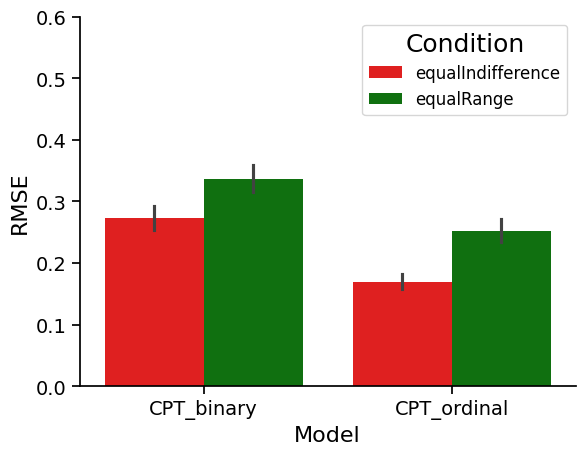

In [117]:
palette = ["red", "green"]
sns.barplot(results_df.query("param_name == 'alpha'"), 
            x = "model", 
            y = "rmse", 
            hue = "condition", 
            palette = palette,)
# remove top and right spines
sns.despine()
# Change labels of axis
plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Model", fontsize=16)
# change fontsize for ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# X label
plt.xlabel("Model")
# Change legend title
plt.legend(title="Condition", fontsize=12)
plt.ylim(0, 0.6)


In [120]:
for param in params:
    print("Param", param)
    print("CPT binary equalIndifference vs CPT binary equalRange")
    print(stats.ttest_ind(results_df.query(f"param_name == '{param}' & model == 'CPT_binary' & condition == 'equalIndifference'")["rmse"],
                          results_df.query(f"param_name == '{param}' & model == 'CPT_binary' & condition == 'equalRange'")["rmse"]))
    print("CPT ordinal equalIndifference vs CPT ordinal equalRange")
    print(stats.ttest_ind(results_df.query(f"param_name == '{param}' & model == 'CPT_ordinal' & condition == 'equalIndifference'")["rmse"],
                          results_df.query(f"param_name == '{param}' & model == 'CPT_ordinal' & condition == 'equalRange'")["rmse"]))
    print("CPT_binary equalIndifference vs CPT ordinal equalIndifference")
    print(stats.ttest_ind(results_df.query(f"param_name == '{param}' & model == 'CPT_binary' & condition == 'equalIndifference'")["rmse"],
                          results_df.query(f"param_name == '{param}' & model == 'CPT_ordinal' & condition == 'equalIndifference'")["rmse"]))
    print("CPT_binary equalRange vs CPT ordinal equalRange")
    print(stats.ttest_ind(results_df.query(f"param_name == '{param}' & model == 'CPT_binary' & condition == 'equalRange'")["rmse"],
                          results_df.query(f"param_name == '{param}' & model == 'CPT_ordinal' & condition == 'equalRange'")["rmse"]))
    print()

Param lambd
CPT binary equalIndifference vs CPT binary equalRange
TtestResult(statistic=np.float64(0.13060379637607666), pvalue=np.float64(0.8961132888542671), df=np.float64(1070.0))
CPT ordinal equalIndifference vs CPT ordinal equalRange
TtestResult(statistic=np.float64(-3.477497466944825), pvalue=np.float64(0.0005269468574980623), df=np.float64(1045.0))
CPT_binary equalIndifference vs CPT ordinal equalIndifference
TtestResult(statistic=np.float64(8.132220857480913), pvalue=np.float64(1.1179844035934536e-15), df=np.float64(1111.0))
CPT_binary equalRange vs CPT ordinal equalRange
TtestResult(statistic=np.float64(3.3384361594905245), pvalue=np.float64(0.000873468136956955), df=np.float64(1004.0))

Param alpha
CPT binary equalIndifference vs CPT binary equalRange
TtestResult(statistic=np.float64(-4.410505275824678), pvalue=np.float64(1.1354347751252373e-05), df=np.float64(1070.0))
CPT ordinal equalIndifference vs CPT ordinal equalRange
TtestResult(statistic=np.float64(-7.177950717251869)

In [167]:
params = ["lambd", "alpha"]
conditions = ["equalIndifference", "equalRange"]
results_2 = {"model" : [], "real_i" : [], "real_j" : [], "auc" : [], "param_name" : [], "condition" : []}
for param in params:
    for condition in conditions:
        for m in ["CPT_binary", "CPT_ordinal"]:
            f1 = df.query(f"param_names == '{param}' & condition == '{condition}' & model == '{m}'")
            paramreal_vals = f1["real"].unique()
            for i in range(len(paramreal_vals)):
                for j in range(len(paramreal_vals)):
                    pred_i = f1.query(f"real == {paramreal_vals[i]}")["estimates"].values
                    pred_j = f1.query(f"real == {paramreal_vals[j]}")["estimates"].values
                    auc = roc_auc_score([1] * len(pred_i) + [0] * len(pred_j), np.concatenate([pred_i, pred_j]))
                    if auc < 0.5:
                        auc = 1 - auc
                    results_2["model"].append(m)
                    results_2["real_i"].append(paramreal_vals[i])
                    results_2["real_j"].append(paramreal_vals[j])
                    results_2["auc"].append(auc)
                    results_2["param_name"].append(param)
                    results_2["condition"].append(condition)

results_2_df = pd.DataFrame(results_2)

In [168]:
results_2_df["real_i"] = results_2_df["real_i"].round(2)
results_2_df["real_j"] = results_2_df["real_j"].round(2)

Model: CPT_binary, Condition: equalIndifference, Param: lambd


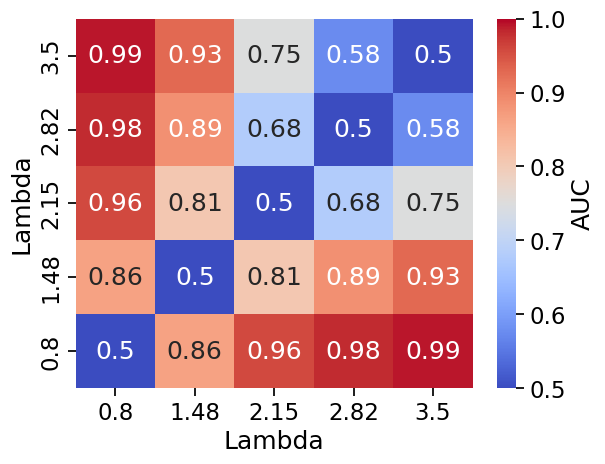

Model: CPT_ordinal, Condition: equalIndifference, Param: lambd


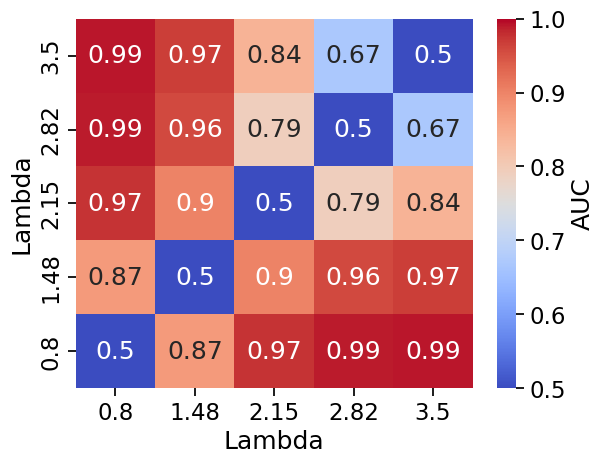

Model: CPT_binary, Condition: equalRange, Param: lambd


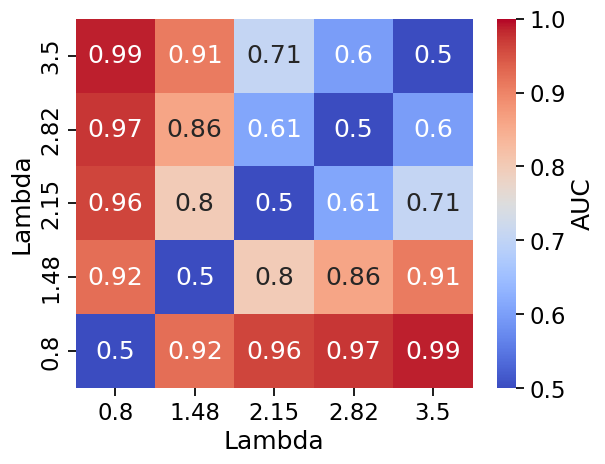

Model: CPT_ordinal, Condition: equalRange, Param: lambd


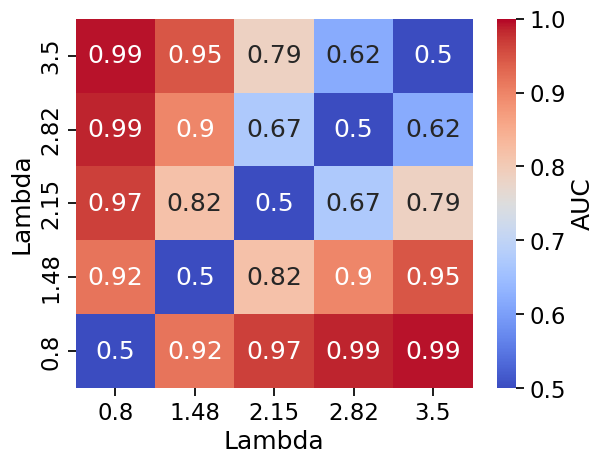

Model: CPT_binary, Condition: equalIndifference, Param: alpha


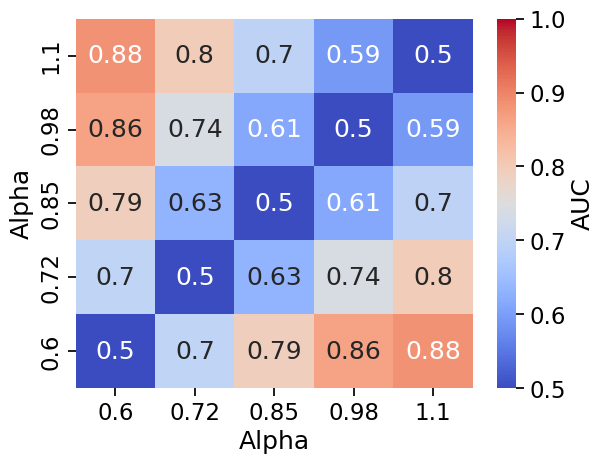

Model: CPT_ordinal, Condition: equalIndifference, Param: alpha


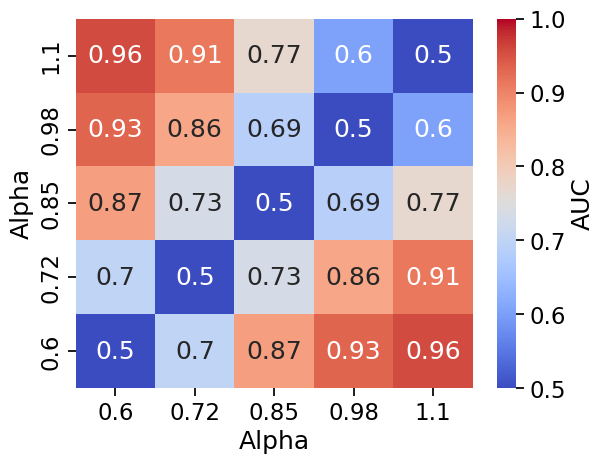

Model: CPT_binary, Condition: equalRange, Param: alpha


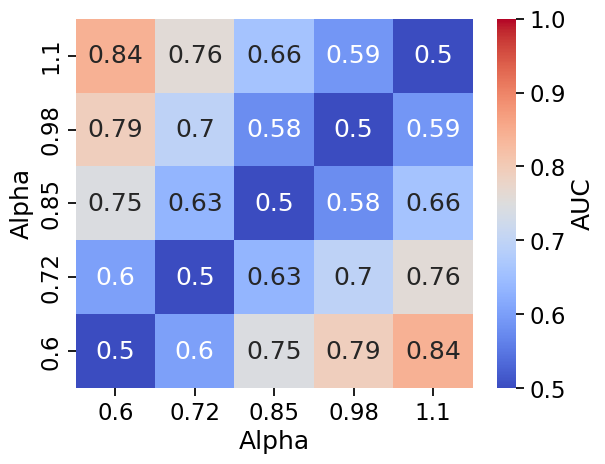

Model: CPT_ordinal, Condition: equalRange, Param: alpha


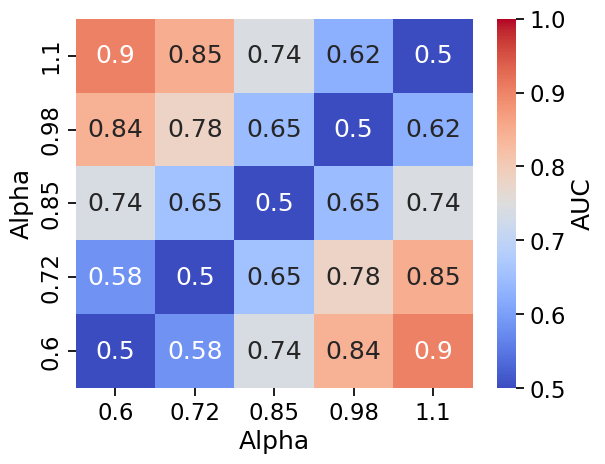

In [171]:
for param in params:
    for condition in conditions:
        for m in ["CPT_binary", "CPT_ordinal"]:
            print(f"Model: {m}, Condition: {condition}, Param: {param}")
            hmap_data = results_2_df.query(f"condition == '{condition}' and param_name == '{param}' and model == '{m}'").groupby(['real_i', 'real_j'])['auc'].mean().unstack()
            hmap_data = hmap_data.iloc[::-1]
            sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'AUC'}, vmin = 0.5, vmax = 1, annot = True)
            # include values inside the heatmap

            if param == "lambd":
                plt.xlabel("Lambda")
                plt.ylabel("Lambda")
            else:
                plt.xlabel("Alpha")
                plt.ylabel("Alpha")
            
            plt.show()

In [175]:
df.query("param_names == 'sigma'")['real'].unique()

array([ 8.        ,  3.        ,  0.5       ,  3.83333333,  4.94444444,
        6.05555556,  7.16666667,  8.27777778,  9.38888889, 10.5       ,
        2.72222222,  1.61111111,  5.5       ])

<Axes: xlabel='real', ylabel='estimates'>

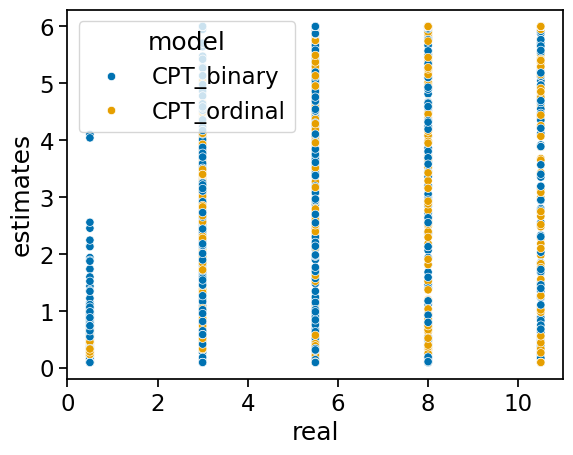

In [183]:
sns.scatterplot(df.query(f"param_names == 'sigma' & model in {["CPT_binary", "CPT_ordinal"]}"), x = 'real', y = 'estimates', hue = 'model')


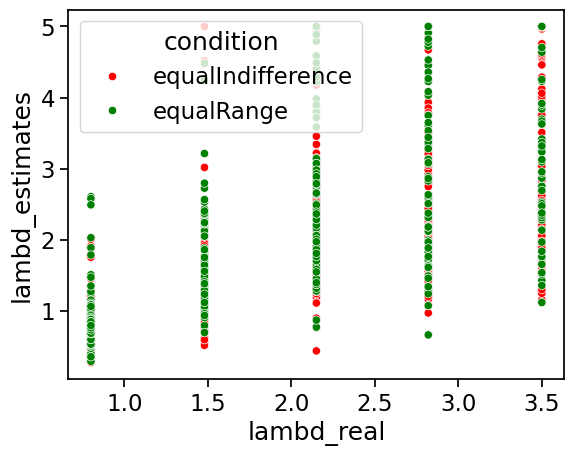

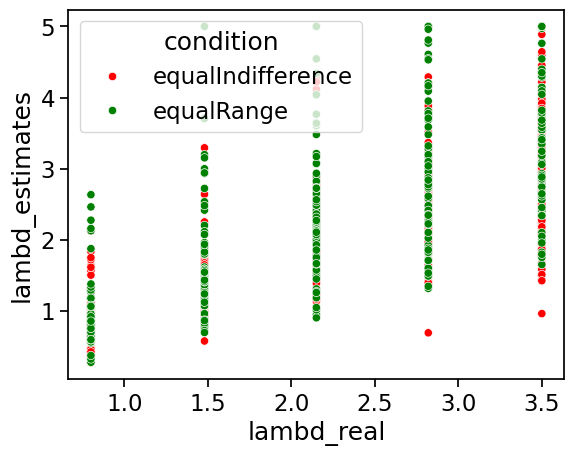

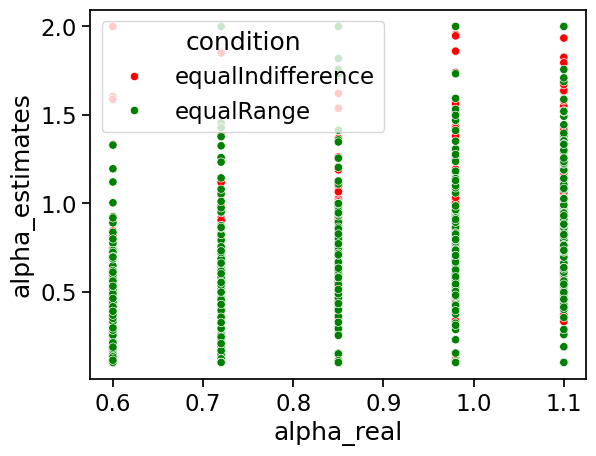

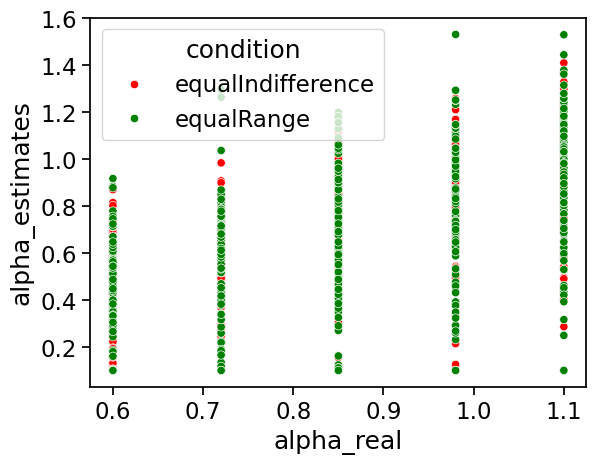

In [127]:
params = ["lambd", "alpha"]
conditions = ["equalIndifference", "equalRange"]
df[f"alpha_real"] = df[f"alpha_real"].round(2)
df[f"lambd_real"] = df[f"lambd_real"].round(2)
for param in params:
        for model, df in zip(["CPT_binary", "CPT_ordinal"], 
                             [CPT_binary_df, CPT_ordinal_df]):
            sns.scatterplot(data=df,
                           x=f"{param}_real",
                           y=f"{param}_estimates",
                           hue="condition",
                           palette=palette,)
            plt.show()

In [67]:
results_df

,model,condition,rmse,r2,param_name
0,CPT_binary,equalIndifference,0.948014,-0.104863,lambd
1,CPT_ordinal,equalIndifference,0.638929,0.499488,lambd
2,CPT_binary,equalRange,1.002574,-0.139310,lambd
3,CPT_ordinal,equalRange,0.856644,0.148682,lambd
4,CPT_binary,equalIndifference,0.352486,-2.994932,alpha
5,CPT_ordinal,equalIndifference,0.227000,-0.663546,alpha
6,CPT_binary,equalRange,0.419682,-4.600042,alpha
7,CPT_ordinal,equalRange,0.332064,-2.513242,alpha


(0.0, 3.5)

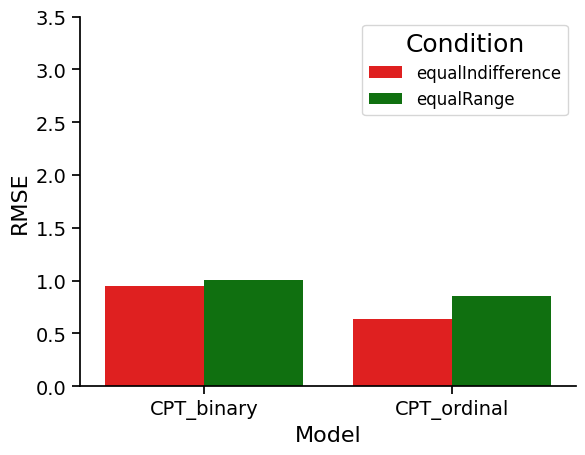

In [86]:
palette = ["red", "green"]
sns.barplot(results_df.query("param_name == 'lambd'"), 
            x = "model", 
            y = "rmse", 
            hue = "condition", 
            palette = palette,)
# remove top and right spines
sns.despine()
# Change labels of axis
plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Model", fontsize=16)
# change fontsize for ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# X label
plt.xlabel("Model")
# Change legend title
plt.legend(title="Condition", fontsize=12)
plt.ylim(0, 3.5)


In [44]:
for condition in ["equalIndifference", "equalRange"]:
    print(f"Condition: {condition}")
    print("CPT_binary")
    a = CPT_binary_df.query(f"condition == '{condition}'")["alpha_estimates"].values
    b = CPT_binary_df.query(f"condition == '{condition}'")["alpha_real"].values
    print(f"Correlation: {np.corrcoef(a, b)[0][1]}")
    
    print("CPT_ordinal")
    a = CPT_ordinal_df.query(f"condition == '{condition}'")["alpha_estimates"].values
    b = CPT_ordinal_df.query(f"condition == '{condition}'")["alpha_real"].values
    print(f"Correlation: {np.corrcoef(a, b)[0][1]}")

Condition: equalIndifference
CPT_binary
Correlation: 0.4810473236411399
CPT_ordinal
Correlation: 0.6661343618827237
Condition: equalRange
CPT_binary
Correlation: 0.4351593783797572
CPT_ordinal
Correlation: 0.5485661333783843


In [ ]:
# Round c_real to nearest 2 decimal places
final_df['c_real'] = final_df['c_real'].round(2)
final_df2['c_real'] = final_df2['c_real'].round(2)

In [85]:
np.corrcoef(final_df['c_real'], final_df['c_estimates']) 

array([[1.        , 0.76422731],
       [0.76422731, 1.        ]])

In [86]:
np.corrcoef(final_df2['c_real'], final_df2['c_estimates']) 

array([[1.        , 0.84445058],
       [0.84445058, 1.        ]])

<Axes: xlabel='c_real', ylabel='c_estimates'>

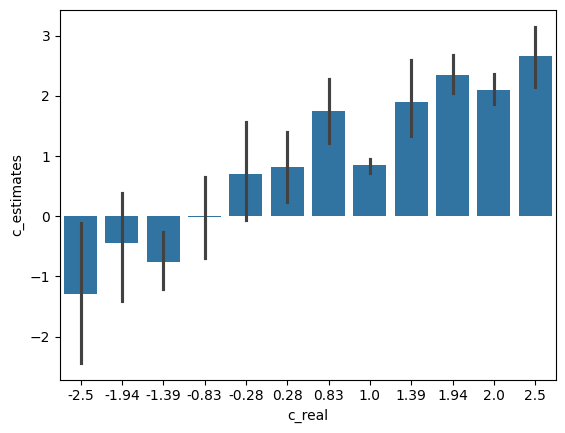

In [88]:
sns.barplot(final_df, x = "c_real", y = "c_estimates")

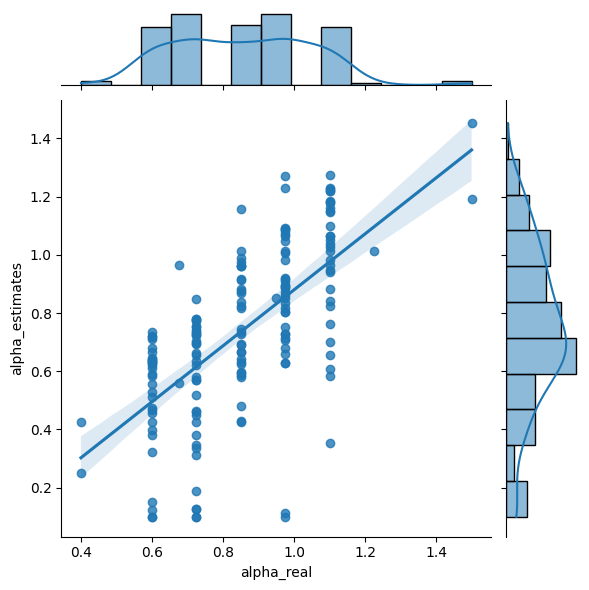

In [95]:
sns.jointplot(data=final_df2, x="alpha_real", y="alpha_estimates", kind="reg")

<Axes: xlabel='c_real', ylabel='c_estimates'>

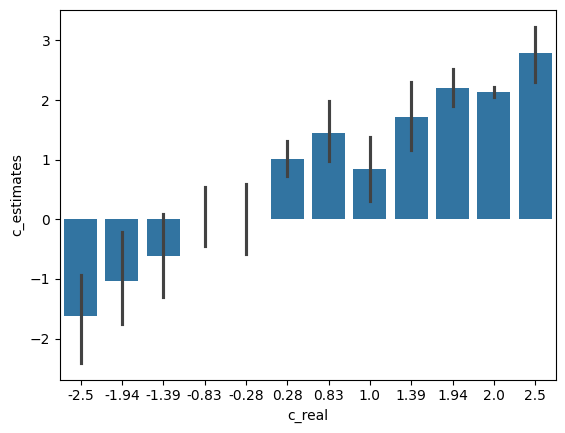

In [89]:
sns.barplot(final_df2, x = "c_real", y = "c_estimates")

<Axes: xlabel='a_2_real', ylabel='a_2_estimates'>

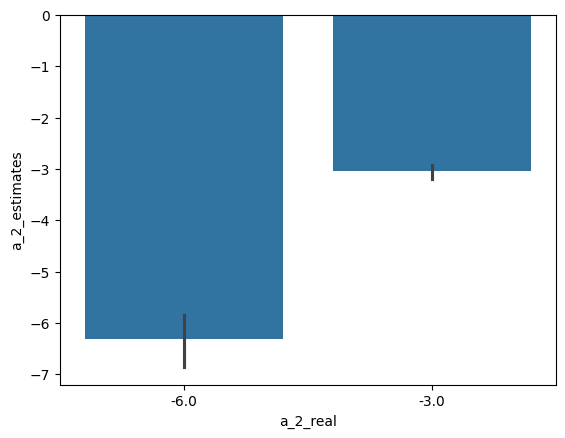

In [42]:
sns.barplot(final_df2, x = "a_2_real", y = "a_2_estimates")

<Axes: xlabel='real', ylabel='estimates'>

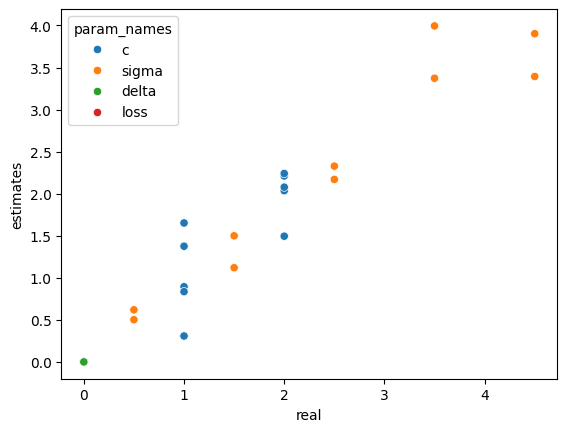

In [6]:
sns.scatterplot(data=df, x = "real", y = "estimates", hue = "param_names")